# Imports and helper methods

In [23]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.model_selection import TimeSeriesSplit
import math
from xgboost import XGBRegressor
from sklearn.feature_selection import mutual_info_regression
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from statsmodels.tsa.deterministic import DeterministicProcess, CalendarFourier, Fourier
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import ElasticNet, Lasso, Ridge, LinearRegression
from sklearn.preprocessing import MinMaxScaler
from statsmodels.graphics.tsaplots import plot_pacf
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import FunctionTransformer
from sklearn.multioutput import MultiOutputRegressor, RegressorChain
from sklearn.compose import make_column_selector
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.callbacks import EarlyStopping
from keras.wrappers.scikit_learn import KerasRegressor
from sklearn.model_selection import GridSearchCV

In [24]:
# A class for boosted hybrid modelling
class BoostedHybrid:
    def __init__(self, model_1, model_2):
        self.model_1 = model_1
        self.model_2 = model_2
        self.y_columns = None  # store column names from fit method
        
    def fit(self, X_1, X_2, y):
        # YOUR CODE HERE: fit self.model_1
        self.model_1.fit(X_1, y)

        y_fit = pd.DataFrame(
            # YOUR CODE HERE: make predictions with self.model_1
            self.model_1.predict(X_1),
            index=X_1.index, columns=y.columns,
        )

        # YOUR CODE HERE: compute residuals
        y_resid = y-y_fit
        y_resid = y_resid.stack().squeeze() # wide to long

        # YOUR CODE HERE: fit self.model_2 on residuals
        self.model_2.fit(X_2, y_resid)

        # Save column names for predict method
        self.y_columns = y.columns
        
        # Save data for question checking
        self.y_fit = y_fit
        self.y_resid = y_resid


    def predict(self, X_1, X_2):
        y_pred = pd.DataFrame(
            # YOUR CODE HERE: predict with self.model_1
            self.model_1.predict(X_1),
            index=X_1.index, columns=self.y_columns,
        )
        y_pred = y_pred.stack().squeeze()  # wide to long

        # YOUR CODE HERE: add self.model_2 predictions to y_pred
        y_pred += self.model_2.predict(X_2)

        return y_pred.unstack()  # long to wide



In [25]:
# Create features and shift output
def make_lags(ts, lags, lead_time=1):
    return pd.concat(
        {
            f'y_lag_{i}': ts.shift(i)
            for i in range(lead_time, lags + lead_time)
        },
        axis=1)

# Create features and shift output
def make_leads(ts, leads, lag_time=1):
    return pd.concat(
        {
            f'y_lag_{i}': ts.shift(-i)
            for i in range(lag_time, leads + lag_time)
        },
        axis=1)

def make_multistep_target(ts, steps):
    return pd.concat(
        {f'y_step_{i + 1}': ts.shift(-i)
         for i in range(steps)},
        axis=1)

def make_lags_transformer(n_lags):
    return FunctionTransformer(lambda x: make_lags(x, n_lags))

def make_leads_transformer(n_leads):
    return FunctionTransformer(lambda x: make_leads(x, n_leads))

# Encode these as sine/cosine features to capture cyclical nature
def sin_transformer(period):
    return FunctionTransformer(lambda x: np.sin(x / period * 2 * np.pi))

def cos_transformer(period):
    return FunctionTransformer(lambda x: np.cos(x / period * 2 * np.pi))

def data_shift_transformer():
    return FunctionTransformer(lambda x: x.dropna())

In [26]:
# Plotting helpers
plot_params = dict(
    color="0.75",
    style=".-",
    markeredgecolor="0.25",
    markerfacecolor="0.25",
)
%config InlineBackend.figure_format = 'retina'


def plot_multistep(y, every=1, ax=None, palette_kwargs=None):
    palette_kwargs_ = dict(palette='husl', n_colors=16, desat=None)
    if palette_kwargs is not None:
        palette_kwargs_.update(palette_kwargs)
    palette = sns.color_palette(**palette_kwargs_)
    if ax is None:
        fig, ax = plt.subplots()
    ax.set_prop_cycle(plt.cycler('color', palette))
    for date, preds in y[::every].iterrows():
        preds.index = pd.period_range(start=date, periods=len(preds))
        preds.plot(ax=ax)
    return ax

In [27]:
def round_to_nearest_n(data, rounding_level):
    return rounding_level * round(data / rounding_level)

# Preliminary Data Transforms

In [28]:
# Get data
kaituna_data = pd.read_csv('../input/kaitunadata/kaituna_data2019-01-01_2022-10-19.csv',parse_dates=["TimeStamp"])
kaituna_data = pd.read_csv('../input/kaituna-20182022/kaituna_data_2018-01-01_2022-10-19.csv',parse_dates=["TimeStamp"])

kaituna_data["TimeStamp"] = pd.to_datetime(kaituna_data['TimeStamp'], utc=True)
kaituna_data = kaituna_data.set_index("TimeStamp")
kaituna_data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 42039 entries, 2018-01-01 00:00:00+00:00 to 2022-10-25 00:00:00+00:00
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   LakeLevel  42038 non-null  float64
 1   FlowRate   42039 non-null  float64
 2   Gate1      42039 non-null  float64
 3   Gate2      42039 non-null  float64
 4   Gate3      42039 non-null  float64
 5   Rainfall   42039 non-null  float64
dtypes: float64(6)
memory usage: 2.2 MB


In [29]:
#Set random seed
seed = 1
np.random.seed(seed)

In [30]:
#Average gate level
kaituna_data["AverageGate"] = kaituna_data[["Gate1", "Gate2", "Gate3"]].median(axis=1)

# Average gate, rounded to the nearest 100
gate_resolution_level = 100
kaituna_data["AverageGateOrdinal"] = round_to_nearest_n(kaituna_data["AverageGate"], gate_resolution_level)


# Extract hour, day, month, year from TimeStamp
kaituna_data["Hour"] = kaituna_data.index.hour
kaituna_data["DayOfWeek"] = kaituna_data.index.day_of_week
kaituna_data["DayOfYear"] = kaituna_data.index.dayofyear
kaituna_data["Month"] = kaituna_data.index.month
kaituna_data["Year"] = kaituna_data.index.year

In [31]:
#Define categorical columns
categorical_cols = ['Hour', 'DayOfWeek', 'Month', 'Year', 'AverageGateOrdinal']
levels = []
for col in categorical_cols:
    kaituna_data[col] = kaituna_data[col].astype('int')

#Numerical columns
numerical_cols = ['FlowRate','AverageGate','Rainfall','LakeLevel']

In [32]:
# Describe
display(kaituna_data.describe())

# Describe ordinal variables
#print(kaituna_data[categorical_cols].describe())
display(kaituna_data.info())

display(kaituna_data.head())

,LakeLevel,FlowRate,Gate1,Gate2,Gate3,Rainfall,AverageGate,AverageGateOrdinal,Hour,DayOfWeek,DayOfYear,Month,Year
count,42038.000000,42039.000000,42039.000000,42039.000000,42039.000000,42039.000000,42039.000000,42039.000000,42039.000000,42039.000000,42039.000000,42039.000000,42039.000000
mean,279.118063,20.823549,464.637789,466.180547,473.593972,0.173508,479.316872,474.947073,11.498204,2.996004,177.551155,6.342896,2019.918290
std,0.065859,7.572910,362.400824,353.686679,353.479172,0.905346,347.186167,350.697288,6.924449,1.999532,103.234625,3.378378,1.382283
min,278.926000,8.222558,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,2018.000000
25%,279.085000,14.146115,249.000000,249.000000,249.000000,0.000000,280.000000,300.000000,5.000000,1.000000,88.000000,3.000000,2019.000000
50%,279.128000,19.391112,399.000000,350.000000,370.000000,0.000000,399.000000,400.000000,11.000000,3.000000,177.000000,6.000000,2020.000000
75%,279.161000,25.310612,549.000000,549.000000,549.000000,0.000000,549.000000,500.000000,17.500000,5.000000,264.000000,9.000000,2021.000000
max,279.368000,45.757437,1500.000000,1538.000000,1500.000000,31.678639,1500.000000,1500.000000,23.000000,6.000000,366.000000,12.000000,2022.000000


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 42039 entries, 2018-01-01 00:00:00+00:00 to 2022-10-25 00:00:00+00:00
Data columns (total 13 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   LakeLevel           42038 non-null  float64
 1   FlowRate            42039 non-null  float64
 2   Gate1               42039 non-null  float64
 3   Gate2               42039 non-null  float64
 4   Gate3               42039 non-null  float64
 5   Rainfall            42039 non-null  float64
 6   AverageGate         42039 non-null  float64
 7   AverageGateOrdinal  42039 non-null  int64  
 8   Hour                42039 non-null  int64  
 9   DayOfWeek           42039 non-null  int64  
 10  DayOfYear           42039 non-null  int64  
 11  Month               42039 non-null  int64  
 12  Year                42039 non-null  int64  
dtypes: float64(7), int64(6)
memory usage: 4.5 MB


None

,LakeLevel,FlowRate,Gate1,Gate2,Gate3,Rainfall,AverageGate,AverageGateOrdinal,Hour,DayOfWeek,DayOfYear,Month,Year
TimeStamp,,,,,,,,,,,,,
2018-01-01 00:00:00+00:00,279.167,17.096532,300.0,300.0,300.0,0.0,300.0,300,0,0,1,1,2018
2018-01-01 01:00:00+00:00,279.177,17.023227,300.0,300.0,300.0,0.0,300.0,300,1,0,1,1,2018
2018-01-01 02:00:00+00:00,279.169,17.145464,300.0,300.0,300.0,0.0,300.0,300,2,0,1,1,2018
2018-01-01 03:00:00+00:00,279.172,17.120989,300.0,300.0,300.0,0.0,300.0,300,3,0,1,1,2018
2018-01-01 04:00:00+00:00,279.171,17.120989,300.0,300.0,300.0,0.0,300.0,300,4,0,1,1,2018


# Feature extraction

In [33]:
# Get features and target
# Date features
date_features = [
    #'Hour',
    'DayOfWeek',
    'Month'
]

#Numerical features
numerical_features = [
    'Rainfall',
    'LakeLevel',
    'FlowRate'
]

#Categorical features
categorical_features = [
    'AverageGateOrdinal'
]

#Combine to create the training data for the residuals model
X_raw = kaituna_data[date_features + numerical_features + categorical_features]

display(X_raw.shape)
display(X_raw.head())
display(X_raw.info())

(42039, 6)

,DayOfWeek,Month,Rainfall,LakeLevel,FlowRate,AverageGateOrdinal
TimeStamp,,,,,,
2018-01-01 00:00:00+00:00,0,1,0.0,279.167,17.096532,300
2018-01-01 01:00:00+00:00,0,1,0.0,279.177,17.023227,300
2018-01-01 02:00:00+00:00,0,1,0.0,279.169,17.145464,300
2018-01-01 03:00:00+00:00,0,1,0.0,279.172,17.120989,300
2018-01-01 04:00:00+00:00,0,1,0.0,279.171,17.120989,300


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 42039 entries, 2018-01-01 00:00:00+00:00 to 2022-10-25 00:00:00+00:00
Data columns (total 6 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   DayOfWeek           42039 non-null  int64  
 1   Month               42039 non-null  int64  
 2   Rainfall            42039 non-null  float64
 3   LakeLevel           42038 non-null  float64
 4   FlowRate            42039 non-null  float64
 5   AverageGateOrdinal  42039 non-null  int64  
dtypes: float64(3), int64(3)
memory usage: 2.2 MB


None

### Summarising into daily 

Having initially tried hourly predictions, I quickly found two things:

1. Rainfall data was hard to use as it was mostly 0s
2. The number of timesteps predicting into the future were difficult to deal with and took a long time to train. 

Daily is perhaps more useful anyway, given how kayakers plan

In [34]:
def is_weekend(row):    
    return (row['DayOfWeek'] == 5) or (row["DayOfWeek"] == 6)

def aggregate_to_daily(hourly_data):
    X_daily = hourly_data.groupby(by=hourly_data.index.date).agg(
        Rainfall = ('Rainfall','sum'), 
        LakeLevel=('LakeLevel','mean'),
        DayOfWeek = ('DayOfWeek', lambda x:x[0]),
        Month = ('Month', lambda x:x[0]),
        AverageGateOrdinal = ('AverageGateOrdinal', lambda x:pd.Series.mode(x)[0]),
        FlowRate = ('FlowRate','median'),
        #IsWeekend = ('DayOfWeek', lambda x: 1 if (pd.Series.mode(x) == 5.0) | (pd.Series.mode(x) == 6.0) else 0)
    )

    X_daily["IsWeekend"] = X_daily.apply(is_weekend, axis=1)
    
    return X_daily

X_daily = aggregate_to_daily(X_raw)

#Set target variable
target_column="AverageGateOrdinal"

X_daily.index = pd.to_datetime(X_daily.index)
X_daily.set_index(X_daily.index.to_period('D'), inplace=True)

display(X_daily.info())
display(X_daily.head())

X_daily.to_csv('kaituna_daily.csv')

<class 'pandas.core.frame.DataFrame'>
PeriodIndex: 1758 entries, 2018-01-01 to 2022-10-25
Freq: D
Data columns (total 7 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Rainfall            1758 non-null   float64
 1   LakeLevel           1758 non-null   float64
 2   DayOfWeek           1758 non-null   int64  
 3   Month               1758 non-null   int64  
 4   AverageGateOrdinal  1758 non-null   int64  
 5   FlowRate            1758 non-null   float64
 6   IsWeekend           1758 non-null   bool   
dtypes: bool(1), float64(3), int64(3)
memory usage: 97.9 KB


None

,Rainfall,LakeLevel,DayOfWeek,Month,AverageGateOrdinal,FlowRate,IsWeekend
2018-01-01,2.420,279.174583,0,1,300,17.120989,False
2018-01-02,11.132,279.168833,1,1,500,23.679429,False
2018-01-03,5.324,279.165042,2,1,500,23.624791,False
2018-01-04,122.936,279.210000,3,1,500,24.407486,False
2018-01-05,53.724,279.347958,4,1,1400,41.085130,False


### Sanity checks on daily summaries

In [35]:
# Shape
print(X_daily.shape)

# Describe
print(X_daily.describe())

# Describe ordinal variables
print(X_daily[categorical_features].describe())

(1758, 7)
          Rainfall    LakeLevel    DayOfWeek        Month  AverageGateOrdinal  \
count  1758.000000  1758.000000  1758.000000  1758.000000         1758.000000   
mean      4.149102   279.118002     2.996018     6.340159          465.756542   
std      10.979284     0.065621     2.001276     3.377803          340.526346   
min       0.000000   278.931125     0.000000     1.000000            0.000000   
25%       0.000000   279.085271     1.000000     3.000000          300.000000   
50%       0.000000   279.127667     3.000000     6.000000          400.000000   
75%       2.726120   279.161719     5.000000     9.000000          500.000000   
max     155.250000   279.347958     6.000000    12.000000         1500.000000   

          FlowRate  
count  1758.000000  
mean     20.682349  
std       7.410285  
min      11.619214  
25%      14.160470  
50%      19.365329  
75%      25.295512  
max      45.069396  
       AverageGateOrdinal
count         1758.000000
mean           465.

### Seasonal features

,"sin(1,freq=A-DEC)","cos(1,freq=A-DEC)","sin(1,1461)","cos(1,1461)"
2018-01-01,0.000000,1.000000,0.000000,1.000000
2018-01-02,0.017213,0.999852,0.004301,0.999991
2018-01-03,0.034422,0.999407,0.008601,0.999963
2018-01-04,0.051620,0.998667,0.012901,0.999917
2018-01-05,0.068802,0.997630,0.017202,0.999852


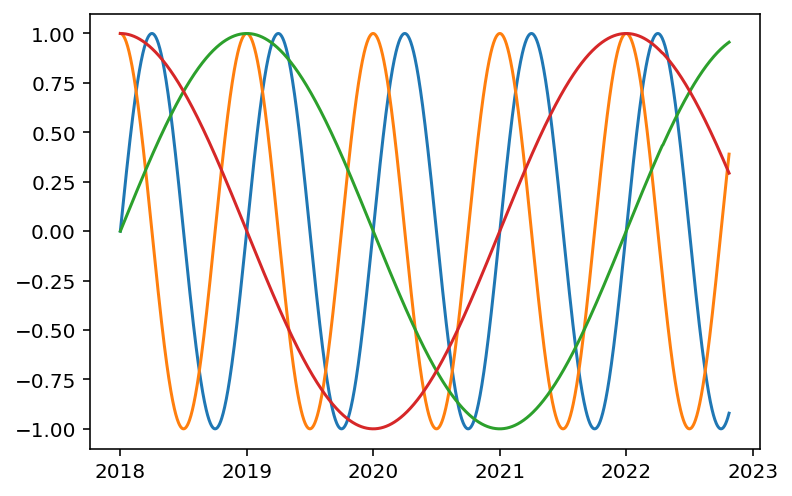

In [36]:
# Trend feature (unused currently)
calendar_fourier = CalendarFourier(freq="A", order=1)#10 sin/cos pairs for "A"nnual seasonality
fourier = Fourier(period=365.25*4, order=1)

#Features for linear regression
dp = DeterministicProcess(
    index=X_daily.index,  # dates from the training data
    constant=False,       # dummy feature for the bias (y_intercept)
    order=0,             # the time dummy (trend)
    additional_terms = [calendar_fourier, fourier],
    drop=True,           # drop terms if necessary to avoid collinearity
)

X_seasonal_features = dp.in_sample()
display(X_seasonal_features.head())

plt.figure()
test = X_seasonal_features.index.to_timestamp()
plt.plot(test, X_seasonal_features.values)
plt.show()

Although there are strong and interesting seasonal components, this is as a result of rainfall. Since we have access to rainfall data, if we include both, we are including highly correlated features.

# Model creation

## Preprocessing

### Lag generator pipeline

### Create input feature set

In [37]:
# Days to look back
n_target_lags = 1
n_rainfall_lags = 1 
n_lake_level_lags = 1
n_rainfall_leads = 3 

# Bundle preprocessing for data.
lag_generator = ColumnTransformer(
    transformers=[
        ("target_lags", make_lags_transformer(n_target_lags), [target_column]),
        ("rainfall_lags", make_lags_transformer(n_rainfall_lags), ["Rainfall"]),
        ("lakelevel_lags", make_lags_transformer(n_lake_level_lags), ["LakeLevel"]),
        ("rainfall_leads", make_leads_transformer(n_rainfall_leads), ["Rainfall"]),
    ],
    remainder='passthrough'
)

lead_lag_col_names = ["Target_lag","Rainfall_lag","LakeLevel_lag",
                 "Rainfall_lead_1",
                 "Rainfall_lead_2",
                "Rainfall_lead_3"]

In [38]:
# Select data for model fitting
X_cols_of_interest = X_daily[["Rainfall","LakeLevel",target_column, "IsWeekend"]]

# Create lags
X_lags = pd.DataFrame(lag_generator.fit_transform(X_cols_of_interest),
                      index = X_daily.index,
                     columns=lead_lag_col_names + ["IsWeekend"])

X = pd.concat([X_lags, X_daily["Rainfall"]], axis=1)

#X = X_lags

#Drop nan
X = X.dropna()

display(X)

,Target_lag,Rainfall_lag,LakeLevel_lag,Rainfall_lead_1,Rainfall_lead_2,Rainfall_lead_3,IsWeekend,Rainfall
2018-01-02,300.0,2.420,279.174583,5.324,122.936,53.724,0.0,11.132
2018-01-03,500.0,11.132,279.168833,122.936,53.724,21.296,0.0,5.324
2018-01-04,500.0,5.324,279.165042,53.724,21.296,18.392,0.0,122.936
2018-01-05,500.0,122.936,279.210000,21.296,18.392,0.000,0.0,53.724
2018-01-06,1400.0,53.724,279.347958,18.392,0.000,0.000,1.0,21.296
...,...,...,...,...,...,...,...,...
2022-10-18,1500.0,0.000,279.184667,0.000,0.000,0.000,0.0,3.000
2022-10-19,1500.0,3.000,279.177667,0.000,0.000,0.000,0.0,0.000
2022-10-20,1500.0,0.000,279.162250,0.000,0.000,0.000,0.0,0.000
2022-10-21,500.0,0.000,279.155583,0.000,0.000,0.000,0.0,0.000


### Create target variable

In [39]:
# Create target variable
n_steps_to_predict = 3
multi_step_predict = False if n_steps_to_predict == 1 else True
y = pd.DataFrame(X_daily[target_column]) if n_steps_to_predict == 1 else make_multistep_target(X_daily[target_column],n_steps_to_predict)
y = y.dropna()

# Align the X and y
y, X = y.align(X, join='inner', axis=0)
display(X.head())
display(y.head())

,Target_lag,Rainfall_lag,LakeLevel_lag,Rainfall_lead_1,Rainfall_lead_2,Rainfall_lead_3,IsWeekend,Rainfall
2018-01-02,300.0,2.420,279.174583,5.324,122.936,53.724,0.0,11.132
2018-01-03,500.0,11.132,279.168833,122.936,53.724,21.296,0.0,5.324
2018-01-04,500.0,5.324,279.165042,53.724,21.296,18.392,0.0,122.936
2018-01-05,500.0,122.936,279.210000,21.296,18.392,0.000,0.0,53.724
2018-01-06,1400.0,53.724,279.347958,18.392,0.000,0.000,1.0,21.296


,y_step_1,y_step_2,y_step_3
2018-01-02,500,500.0,500.0
2018-01-03,500,500.0,1400.0
2018-01-04,500,1400.0,1400.0
2018-01-05,1400,1400.0,1400.0
2018-01-06,1400,1400.0,1400.0


## Preprocessing pipeline

In [40]:
# Preprocessing for pca
pca_pipeline = Pipeline(steps=[
    #('scale', StandardScaler()),
    #('pca', PCA()),
    ('scaler', StandardScaler())
])

# Bundle preprocessing for all data
preprocessor = ColumnTransformer(
    transformers=[
        ('num', pca_pipeline, lead_lag_col_names)
    ],
remainder = 'passthrough')

### Model definition

In [41]:
# Model definition
def CreateKaitunaNN(input_size, output_size):
    model = keras.Sequential([
        layers.Dense(units=100, activation='relu', input_shape=([input_size])), #todo make this not a magic number
        layers.Dropout(0.1),
        layers.Dense(units=50, activation='relu'),
        layers.Dense(units=25, activation='relu'),
        layers.Dense(units=output_size),
    ])

    model.compile(
        optimizer=tf.keras.optimizers.Adam(epsilon=0.01),
        loss='mean_squared_error',
    )
    
    return model

early_stopping = EarlyStopping(
    min_delta=0.001, # minimium amount of change to count as an improvement
    patience=20, # how many epochs to wait before stopping
    restore_best_weights=True,
)

n_epochs = 2000
verbose=0

# Model preprocessing

### Pipeline creation

In [42]:
cross_val_preprocessor = preprocessor
cross_val_model = KerasRegressor(build_fn=CreateKaitunaNN,
                                 input_size=X.shape[1],
                                 output_size=y.shape[1],
                                 epochs=n_epochs,
                                 callbacks=[early_stopping],
                                verbose=verbose)

cross_val_pipeline = Pipeline(steps=[
    ("preprocessing",cross_val_preprocessor),
    ("model", cross_val_model)
])

In [ ]:
# Cross validation
n_splits=5
tscv = TimeSeriesSplit(gap=0, max_train_size=None, n_splits=n_splits)
scores = cross_val_score(cross_val_pipeline,
                         X,
                         y,
                         cv=tscv,
                         scoring='neg_mean_squared_error',
                         #fit_params={'model__callbacks':[early_stopping]}
                        )
scores = -scores
display(scores)
display(np.sqrt(scores))
display(np.median(np.sqrt(scores)))

# Training the final model

In [ ]:
final_preprocessor = preprocessor
final_model = KerasRegressor(build_fn=CreateKaitunaNN,
                                 input_size=X.shape[1],
                                 output_size=y.shape[1],
                                 epochs=n_epochs,
                                 callbacks=[early_stopping],
                                verbose=verbose)

final_pipeline = Pipeline(steps=[
    ("preprocessing",final_preprocessor),
    ("model", final_model)
])

In [ ]:
# Test train split for hybrid model fitting
X_train_df, X_test_df, y_train, y_test = train_test_split(X, y, test_size=0.333, shuffle=False)

## Train and predict

In [ ]:
history = final_pipeline.fit(X_train_df, y_train)

y_fit = pd.DataFrame(final_pipeline.predict(X_train_df), index=X_train_df.index, columns=y_train.columns)
y_pred = pd.DataFrame(final_pipeline.predict(X_test_df), index=X_test_df.index, columns=y_test.columns)

## Results

In [ ]:
# Round to chosen gate resolution
#if target_column == 'AverageGateOrdinal':
#    y_fit = round_to_nearest_n(y_fit, gate_resolution_level)
#    y_pred = round_to_nearest_n(y_pred, gate_resolution_level)

train_rmse = mean_squared_error(y_train, y_fit, squared=False)
test_rmse = mean_squared_error(y_test, y_pred, squared=False)

print((f"Train RMSE: {train_rmse:.2f}\n" f"Test RMSE: {test_rmse:.2f}"))

In [ ]:
# Visualise results of multi-step output

if multi_step_predict == True:
    palette = dict(palette='husl', n_colors=64)
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(20, 10))

    ax1 = X_daily[target_column][y_fit.index].plot(ax=ax1)
    ax1 = plot_multistep(y_fit, ax=ax1, palette_kwargs=palette)
    _ = ax1.legend(['Flowrate (train)', 'Forecast'])

    ax2 = X_daily[target_column][y_pred.index].plot(**plot_params, ax=ax2)
    ax2 = plot_multistep(y_pred, ax=ax2, palette_kwargs=palette)
    _ = ax2.legend(['Flowrate (test)', 'Forecast'])
else:    
    # Visualise results
    axs = y.loc(axis=1)[target_column].plot(
        subplots=True, sharex=True, figsize=(20, 10), **plot_params, alpha=0.5,
    )
    _ = y_fit.loc(axis=1)[target_column].plot(subplots=True, sharex=True, color='C0', ax=axs)
    _ = y_pred.loc(axis=1)[target_column].plot(subplots=True, sharex=True, color='C3', ax=axs)

    plt.xlabel("Date")
    plt.ylabel('Flowrate (cumecs)')
    plt.legend(["Actual","Training","Validation"])

# Show the learning curves
"""history_df = pd.DataFrame(final_model.history)
history_df.loc[:, ['loss', 'val_loss']].plot();
plt.ylim([0,30])
plt.show()"""

In [ ]:
import joblib
import pickle as pk

# Export model
output_directory = './'
filename = "flow_rate_predictor/"

# Save model
saved_model = final_pipeline.named_steps['model']
saved_model.model.save(filename + 'saved_model.h5')

# Export preprocessing pipeline
pk.dump(final_preprocessor, open(filename + "preprocessor.pkl","wb"))

In [ ]:
# Download file
import os
from IPython.display import FileLink
os.chdir(r'/kaggle/working')

!zip -r model.zip /kaggle/working/flow_rate_predictor
FileLink(r'model.zip')